<a href="https://colab.research.google.com/github/ashleyohoh05/INSY-695_Assignment2/blob/main/MGSC673_Intro_to_AI_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## CNN vs. Transfer Learning on CIFAR-10

# ## 0. Setup & Imports
import time, copy, random
import torch, torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchmetrics.classification import MulticlassAccuracy

# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}\n")

Running on cuda



In [ ]:
## 1. Dataset Usage
# transforms
mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
tf_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
tf_test  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# download + split
full_train = datasets.CIFAR10("data", train=True,  download=True, transform=tf_train)
test_set   = datasets.CIFAR10("data", train=False, download=True, transform=tf_test)

val_size   = 5_000
train_size = len(full_train) - val_size
train_set, val_set = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print("Dataset sizes:")
print(f"  • Train:      {len(train_set)} images")
print(f"  • Validation: {len(val_set)} images")
print(f"  • Test:       {len(test_set)} images\n")

# dataloaders
BATCH = 128
train_dl = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_set,   batch_size=256,   shuffle=False, num_workers=4)
test_dl  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=4)

# FIX for transfer learning validation
tf_val_tl = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
val_ds_tl = datasets.CIFAR10("data", train=True, download=False, transform=tf_val_tl)
val_subset_tl = torch.utils.data.Subset(val_ds_tl, val_set.indices)
val_dl_tl = DataLoader(val_subset_tl, batch_size=256, shuffle=False, num_workers=4)

Dataset sizes:
  • Train:      45000 images
  • Validation: 5000 images
  • Test:       10000 images



Training Scratch CNN
[Epoch 01] train_loss=1.392 train_acc=0.495  |  val_loss=1.063 val_acc=0.619
[Epoch 02] train_loss=0.969 train_acc=0.659  |  val_loss=0.818 val_acc=0.712
[Epoch 03] train_loss=0.799 train_acc=0.719  |  val_loss=0.719 val_acc=0.749
[Epoch 04] train_loss=0.704 train_acc=0.756  |  val_loss=0.665 val_acc=0.764
[Epoch 05] train_loss=0.642 train_acc=0.775  |  val_loss=0.585 val_acc=0.796
[Epoch 06] train_loss=0.583 train_acc=0.798  |  val_loss=0.603 val_acc=0.790
[Epoch 07] train_loss=0.542 train_acc=0.813  |  val_loss=0.531 val_acc=0.813
[Epoch 08] train_loss=0.504 train_acc=0.825  |  val_loss=0.531 val_acc=0.813
[Epoch 09] train_loss=0.476 train_acc=0.836  |  val_loss=0.488 val_acc=0.829
[Epoch 10] train_loss=0.451 train_acc=0.843  |  val_loss=0.470 val_acc=0.836
[Epoch 11] train_loss=0.418 train_acc=0.854  |  val_loss=0.468 val_acc=0.842
[Epoch 12] train_loss=0.410 train_acc=0.857  |  val_loss=0.469 val_acc=0.838
[Epoch 13] train_loss=0.388 train_acc=0.864  |  val_los

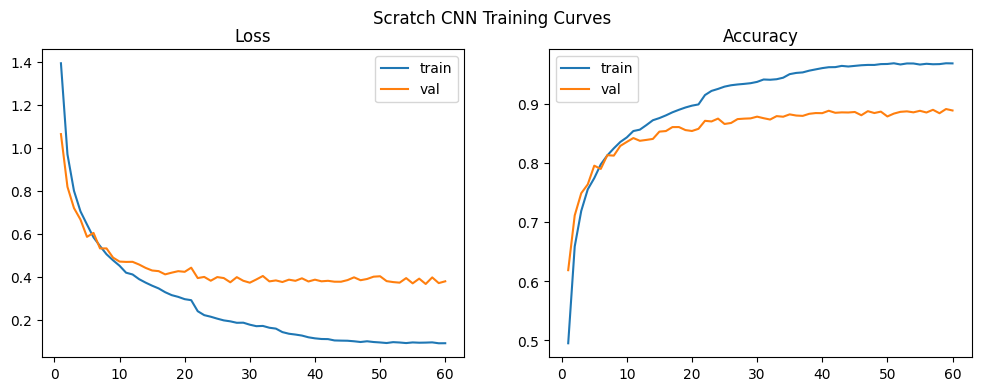

In [ ]:
## 2. Part 1 – CNN from Scratch
# Model Training
# Model Evaluation
# Training Curves

# 2.1 Define the small CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1),   nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # 16×16
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # 8×8
            nn.Conv2d(128,256,3,padding=1),nn.ReLU(),nn.BatchNorm2d(256),
            nn.MaxPool2d(2)   # 4×4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model_s    = SmallCNN().to(DEVICE)
criterion  = nn.CrossEntropyLoss()

# helper functions
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train(training)
    accm = MulticlassAccuracy(num_classes=10).to(DEVICE)
    running_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.set_grad_enabled(training):
            out = model(xb)
            loss = criterion(out, yb)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        running_loss += loss.item() * xb.size(0)
        accm.update(out, yb)
    return running_loss/len(loader.dataset), accm.compute().item()

def train_model(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    best_w, best_acc = copy.deepcopy(model.state_dict()), 0.0
    train_hist, val_hist = [], []

    for ep in range(epochs):
        tloss, tacc = run_epoch(model, train_loader, optimizer)
        vloss, vacc = run_epoch(model, val_loader, None)
        scheduler.step(vloss)

        train_hist.append((tloss, tacc))
        val_hist.append((vloss, vacc))

        if vacc > best_acc:
            best_acc, best_w = vacc, copy.deepcopy(model.state_dict())
        print(f"[Epoch {ep+1:02d}] train_loss={tloss:.3f} train_acc={tacc:.3f}  |  "
              f"val_loss={vloss:.3f} val_acc={vacc:.3f}")

    model.load_state_dict(best_w)
    return train_hist, val_hist

# 2.2 Train scratch CNN
print("Training Scratch CNN")
t0 = time.time()
hist_s, hist_v = train_model(model_s, train_dl, val_dl, epochs=60, lr=3e-4)
test_loss_s, test_acc_s = run_epoch(model_s, test_dl, None)
time_s = (time.time()-t0)/60
print(f"\nScratch CNN Test -> loss={test_loss_s:.3f}, acc={test_acc_s:.3f}, time={time_s:.1f} min\n")

# ### 2.3 Plot Training Curves (Training Curves 10%)
def plot_curves(train_hist, val_hist, title):
    epochs = np.arange(1, len(train_hist)+1)
    tl, ta = zip(*train_hist)
    vl, va = zip(*val_hist)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].plot(epochs, tl, label="train"), axes[0].plot(epochs, vl, label="val")
    axes[0].set_title("Loss"), axes[0].legend()
    axes[1].plot(epochs, ta, label="train"), axes[1].plot(epochs, va, label="val")
    axes[1].set_title("Accuracy"), axes[1].legend()
    fig.suptitle(title)
    plt.show()

plot_curves(hist_s, hist_v, "Scratch CNN Training Curves")

In [ ]:
## 3. Part 2 – Transfer Learning
# Pre-trained Model Usage
# Model Evaluation
# Comparison & Analysis

# 3.1 Prepare up-sampling dataloaders for ResNet-18
tf_train_tl = transforms.Compose([
    transforms.Resize(224), transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
tf_test_tl  = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
train_tl = datasets.CIFAR10("data", train=True,  download=False, transform=tf_train_tl)
test_tl  = datasets.CIFAR10("data", train=False, download=False, transform=tf_test_tl)
train_dl_tl = DataLoader(train_tl, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
test_dl_tl  = DataLoader(test_tl,  batch_size=256,   shuffle=False, num_workers=4)

# show the modified model architecture
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in resnet.parameters(): p.requires_grad=False
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
model_tl = resnet.to(DEVICE)
print("Modified ResNet-18 final layer:")
print(model_tl.fc, "\n")

# 3.2 Train head only + fine-tune
print("Training only the new head")
t1 = time.time()
train_hist, val_hist = train_model(model_tl, train_dl_tl, val_dl_tl, epochs=5,  lr=1e-3)
print("\nUnfreezing last block + fine-tuning")
for _, p in model_tl.layer4.named_parameters():
    p.requires_grad = True
train_model(model_tl, train_dl_tl, val_dl_tl, epochs=10, lr=1e-4)
test_loss_tl, test_acc_tl = run_epoch(model_tl, test_dl_tl, None)
time_tl = (time.time()-t1)/60
print(f"\nTransfer-Learned Test -> loss={test_loss_tl:.3f}, acc={test_acc_tl:.3f}, time={time_tl:.1f} min\n")

# 3.3 Phase-1: train only the classification head (frozen backbone)
head_train_hist, head_val_hist, _ = train_model(
    model_tl,
    train_dl_tl,
    val_dl_tl,
    epochs=5,
    lr=1e-3,
    freeze_backbone=True
)

# 3.4 Phase-2: unfreeze layer4 and fine-tune
print("\nUnfreezing last block + fine-tuning")
for _, p in model_tl.layer4.named_parameters():
    p.requires_grad = True

ft_train_hist, ft_val_hist, _ = train_model(
    model_tl,
    train_dl_tl,
    val_dl_tl,
    epochs=10,
    lr=1e-4
)

# 3.5 Concatenate the two histories
tl_train_hist = head_train_hist + ft_train_hist
tl_val_hist   = head_val_hist  + ft_val_hist

# 3.6 Plot loss and accuracy
plot_curves(tl_train_hist, tl_val_hist, "ResNet-18 Transfer-Learning Curves")

Modified ResNet-18 final layer:
Linear(in_features=512, out_features=10, bias=True) 

Training only the new head
[Epoch 01] train_loss=0.911 train_acc=0.715  |  val_loss=0.657 val_acc=0.771
[Epoch 02] train_loss=0.625 train_acc=0.789  |  val_loss=0.578 val_acc=0.794
[Epoch 03] train_loss=0.586 train_acc=0.799  |  val_loss=0.571 val_acc=0.798
[Epoch 04] train_loss=0.573 train_acc=0.802  |  val_loss=0.549 val_acc=0.806
[Epoch 05] train_loss=0.560 train_acc=0.808  |  val_loss=0.539 val_acc=0.808

Unfreezing last block + fine-tuning
[Epoch 01] train_loss=0.371 train_acc=0.872  |  val_loss=0.171 val_acc=0.946
[Epoch 02] train_loss=0.177 train_acc=0.940  |  val_loss=0.089 val_acc=0.974
[Epoch 03] train_loss=0.105 train_acc=0.966  |  val_loss=0.058 val_acc=0.984
[Epoch 04] train_loss=0.067 train_acc=0.979  |  val_loss=0.036 val_acc=0.990
[Epoch 05] train_loss=0.042 train_acc=0.987  |  val_loss=0.021 val_acc=0.995
[Epoch 06] train_loss=0.032 train_acc=0.991  |  val_loss=0.014 val_acc=0.996
[Ep